In [104]:
import numpy as np
import matplotlib.pyplot as plt
import functools as ft
from scipy.linalg import expm, sqrtm

## Projected ensemble simulation

We define a Hamiltonian following [Cotler et al.](https://doi.org/10.1103/PRXQuantum.4.010311). It is a one-dimensional spin chain with single-site mixed field terms and nearest neighbour interaction terms, without periodic boundary conditions.

To simulate the dynamics use a naive approach:
- State is a vector, Hamiltonian is a matrix
- Exponentiate Hamiltonian to get time evolution operator
- Matvec multiplication to get final state $\ket{\Psi} = U \ket{\Psi_0}$

With my laptop this is only achievable for $N_A = 1$ and $N_B$ up to about $9$, which hopefully is sufficiently large to get a result.

In [142]:
## Hamiltonian: Quantum Ising spin with mixed fields (QIMF)

# Parameters (as per Cotler et al.)
h_x = 0.8090
h_y = 0.9045
J = 1
N_A = 1
N_B = 3
N = N_A + N_B

# Pauli matrices
sx = np.array([[0,1],[1,0]]) ;  sy = np.array([[0,-1j],[1j,0]])

# Single site term
H1 = h_x * sx + h_y * sy

# Interaction term
H2 = J * np.kron(sx,sx)

# Hamiltonian as a matrix
H = np.zeros((2**N,2**N),dtype='complex128')
for i in range(N):
    H += ft.reduce(np.kron, [np.identity(2**i), H1, np.identity(2**(N-i-1))])
for i in range(N-2):
    H += ft.reduce(np.kron, [np.identity(2**i), H2, np.identity(2**(N-i-2))])

# Initial state: all |0>
Psi0 = np.zeros(2**N)
Psi0[0] = 1

Next, a function to get the projected ensemble as a list. Just get a single state for now. The first qubit is taken to be subsystem $A$, all the others form subsystem $B$.

In [82]:
# First, getting a projected ensemble from the most literal, obvious way: by defining projectors for each measurement outcome

def PrEns(Psi):
    # Define empty ensemble
    PrEns = np.empty((2**N_B, 2)).tolist()

    # Loop over |z_B>, make projectors
    for i in range(2**N_B):
        z_B = np.zeros(2**N_B)
        z_B[i] = 1
        P = np.kron(np.identity(2**N_A), np.outer(z_B,z_B))

        Psi_zB = P @ Psi

        # Pick out probability (norm), then normalise, then get PsiA
        PrEns[i][0] = np.linalg.norm(Psi_zB) ** 2
        Psi_zB /= np.linalg.norm(Psi_zB)
        PrEns[i][1] = Psi_zB.reshape(2**N_A, 2**N_B)[:,i]
    
    return PrEns

# Then I realised, as the labelling zB is not that important to get the moments, we can just read everything off

def PrEns_quick(Psi):
    PrEns = np.empty((2**N_B, 2)).tolist()

    for i in range(2**N_B):
        PsiA = Psi.reshape(2**N_A, 2**N_B)[:,i]
        PrEns[i][0] = np.linalg.norm(PsiA) ** 2
        PrEns[i][1] = PsiA / np.linalg.norm(PsiA)
    
    return PrEns

# A quick check confirms these give the same, so no outer products / matrix vector multiplication is needed.


Now next step is to get these moments and compare to the Haar ensemble. If I do $k = 1, 2, 3$ only I can use the minimal 3-design which I think is easiest.
- Get a function to return the k-th moment
- Figure out that trace norm they use

For now to keep it simple just take $N_A = 1$ everywhere, even though that is less general

In [131]:
# minimal 3-design, only for one qubit!!

Design_3 = [[1/6, np.array([1, 0])],
            [1/6, np.array([0, 1])],
            [1/6, np.array([np.sqrt(1/2), np.sqrt(1/2)])],
            [1/6, np.array([np.sqrt(1/2), -np.sqrt(1/2)])],
            [1/6, np.array([np.sqrt(1/2), np.sqrt(1/2) * 1j])],
            [1/6, np.array([np.sqrt(1/2), -np.sqrt(1/2) * 1j])]]

# Let's start with density matrices. For the 3-design:

rho_1_Haar = np.zeros((2,2),dtype='complex128')
for i in range(6):
    rho_1_Haar += Design_3[i][0] * np.outer(np.conjugate(Design_3[i][1]), Design_3[i][1])


# Then the trace distance measure, for matrices.

def trace_dist(rho,sigma):
    evals, evec = np.linalg.eigh(rho-sigma)
    dist = 0
    for eval in evals:
        dist += abs(eval)
    dist /= 2

    return dist


/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_7920/2629286713.py:30: RuntimeWarning: invalid value encountered in divide
  PrEns[i][1] = PsiA / np.linalg.norm(PsiA)


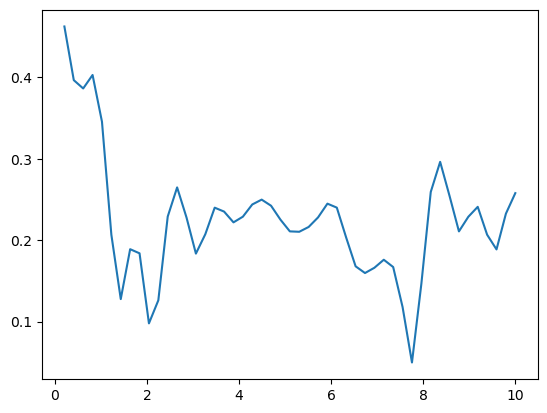

In [143]:
# A test: trace distances for the density matrix

times = np.linspace(0,10,50)
dist = np.zeros(np.size(times))

for i, t in enumerate(times):
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = PrEns_quick(Psi)

    # Get the density matrices
    rho_1_sim = np.zeros((2,2),dtype='complex128')
    for j in range(2**N_B):
        rho_1_sim += PrEns[j][0] * np.outer(np.conjugate(PrEns[j][1]), PrEns[j][1])

    dist[i] = trace_dist(rho_1_Haar,rho_1_sim)

fig = plt.figure()
plt.plot(times, dist)
plt.show()


